<a href="https://colab.research.google.com/github/TusharJiShukla/CS-307-Lab-Report/blob/main/Lab_05_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing necessary libraries for financial analysis and HMM
!pip install yfinance numpy pandas matplotlib hmmlearn

In [ ]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

In [ ]:
def fetch_market_data(symbol, period_start, period_end):
    """
    Downloads historical market data and calculates daily percentage returns.
    """
    # Download data from Yahoo Finance
    df_market = yf.download(symbol, start=period_start, end=period_end)

    df_market['Daily_Returns'] = df_market['Close'].pct_change()

    clean_data = df_market.dropna()
    return clean_data

def train_regime_model(return_series, n_components=2):
    """
    Fits a Gaussian Hidden Markov Model to the provided return series.
    """
    # Reshape data for the HMM (requires 2D array)
    X_train = return_series.reshape(-1, 1)

    # Initialize and fit the Gaussian HMM
    # covariance_type='diag' assumes features are independent
    hmm_model = GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
    hmm_model.fit(X_train)

    # Decode the hidden states (market regimes)
    inferred_states = hmm_model.predict(X_train)

    return hmm_model, inferred_states

In [ ]:
def visualize_regimes(df, states, total_states):
    """
    Visualizes the asset price and returns, colored by the identified market regime.
    """
    df['Regime'] = states

    figure, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Subplot 1: Adjusted Closing Price
    for i in range(total_states):
        mask = df['Regime'] == i
        axes[0].plot(df.index[mask], df['Close'][mask], '.',
                     label=f'STate {i}', color=colors[i % len(colors)], markersize=4)

    axes[0].set_title(f'Asset Price Segmented by Hidden Market States')
    axes[0].set_ylabel('Adjusted Close Price')
    axes[0].legend(loc='upper left')
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Subplot 2: Daily Returns
    for i in range(total_states):
        mask = df['Regime'] == i
        axes[1].plot(df.index[mask], df['Daily_Returns'][mask], '.',
                     label=f'STate {i}', color=colors[i % len(colors)], markersize=4)

    axes[1].set_title('Daily Returns Segmented by Hidden States')
    axes[1].set_ylabel('Percentage Return')
    axes[1].set_xlabel('Date')
    axes[1].legend(loc='upper left')
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

def display_statistics(model, n_components):
    """
    Prints the transition matrix and statistical properties of each hidden state.
    """
    print("--- HMM Model Statistics ---")
    print("\n[1] State Transition Probability Matrix:")
    print(np.round(model.transmat_, 4))

    print("\n[2] Means and Variances of hidden states::")
    for i in range(n_components):
        print(f"  > Hidden State {i}:")
        # Extracting mean and calculating variance from the diagonal covariance
        mean_val = model.means_[i][0]
        var_val = np.diag(model.covars_[i])[0]
        print(f"    Mean Return: {mean_val:.6f}")
        print(f"    Variance:    {var_val:.6f}")
        print("-" * 30)

/tmp/ipython-input-4266850149.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_market = yf.download(symbol, start=period_start, end=period_end)
[*********************100%***********************]  1 of 1 completed


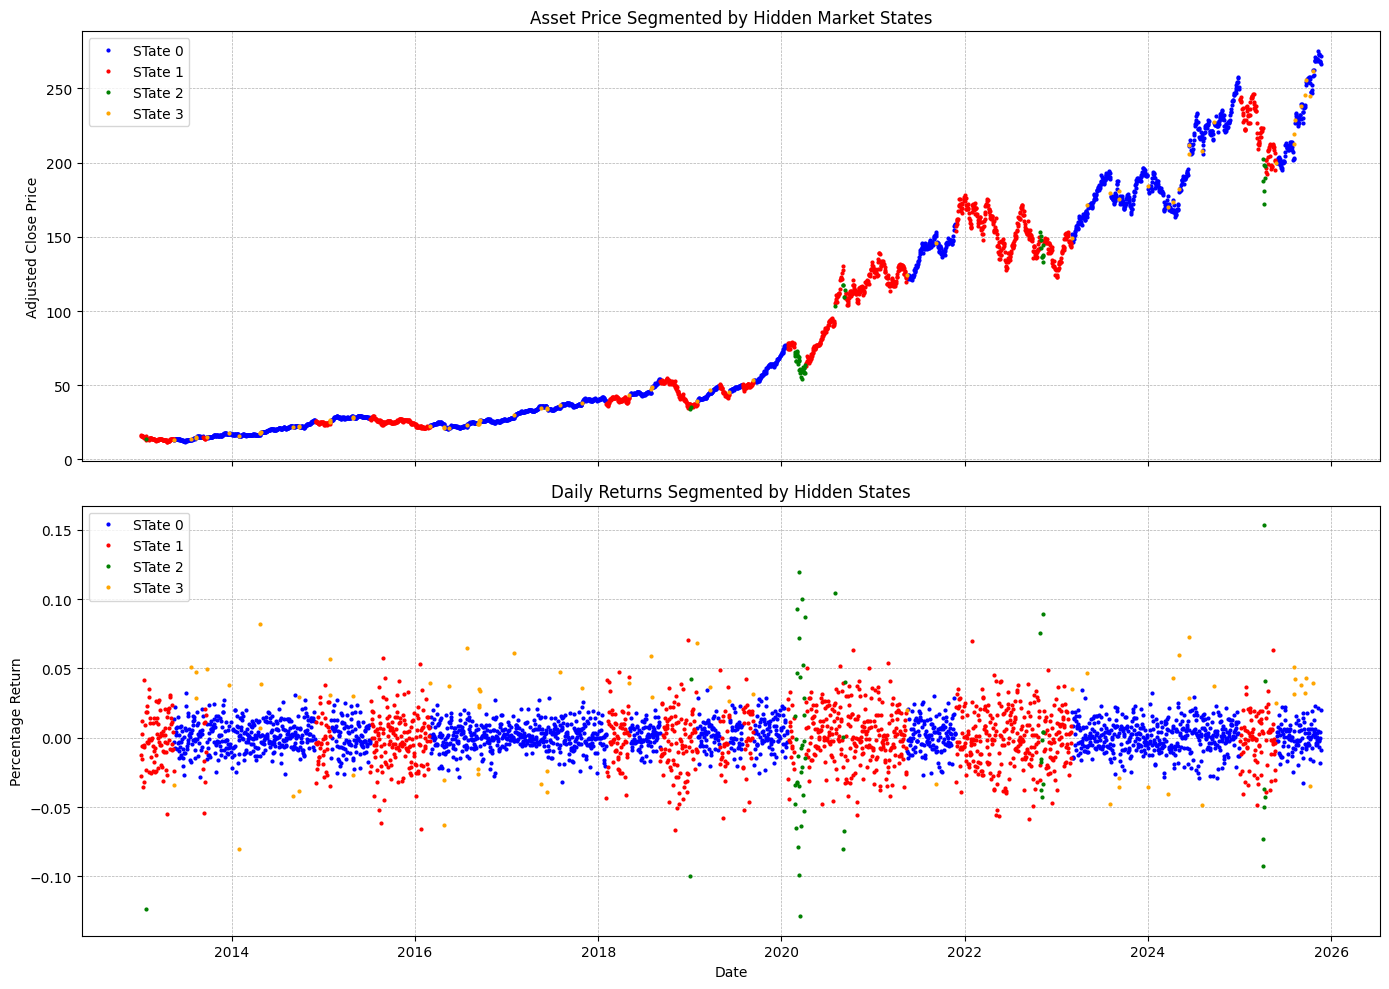

--- HMM Model Statistics ---

[1] State Transition Probability Matrix:
[[0.9358 0.007  0.     0.0572]
 [0.     0.9732 0.012  0.0148]
 [0.     0.1521 0.8479 0.    ]
 [0.5897 0.     0.     0.4103]]

[2] Means and Variances of hidden states::
  > Hidden State 0:
    Mean Return: 0.001464
    Variance:    0.000115
------------------------------
  > Hidden State 1:
    Mean Return: -0.000237
    Variance:    0.000423
------------------------------
  > Hidden State 2:
    Mean Return: -0.004583
    Variance:    0.003148
------------------------------
  > Hidden State 3:
    Mean Return: 0.004820
    Variance:    0.000839
------------------------------


In [ ]:
if __name__ == '__main__':
    target_asset = "AAPL"  # Apple Inc.
    start_dt = "2013-01-01"
    end_dt = datetime.datetime.today().strftime('%Y-%m-%d')
    regime_count = 4
    market_data = fetch_market_data(target_asset, start_dt, end_dt)
    returns_vector = market_data['Daily_Returns'].values
    regime_model, predicted_states = train_regime_model(returns_vector, n_components=regime_count)
    visualize_regimes(market_data, predicted_states, regime_count)
    display_statistics(regime_model, regime_count)